In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda, Dropout, MaxPooling2D, Dense, Flatten
from keras import backend as K
%matplotlib inline

dsb_data_dir = os.path.join("../",'Project/')
stage_label = 'stage1'

Using TensorFlow backend.


### READ IN THE LABELS

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))

train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
727,077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7...,"[47530, 5, 47785, 9, 48040, 11, 48296, 12, 485..."
13931,6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbac...,"[173444, 4, 173959, 11, 174476, 15, 174995, 17..."
27516,ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71...,"[55847, 5, 56102, 8, 56358, 8, 56613, 10, 5686..."


In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
print(img_df.iloc[1]["path"])

../Project\stage1_test\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac\images\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png


### LOAD ALL THE IMAGES

In [4]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
14042,../Project\stage1_train\6c67b78e8164801059375e...,6c67b78e8164801059375ed9a607f61e67a7ae347e92e3...,masks,train,stage1
16540,../Project\stage1_train\8a65e41c630d85c0004ce1...,8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f6...,masks,train,stage1


### CREATE TRAINING DATA

In [5]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 1min 6s


### SHOW A FEW IMAGES

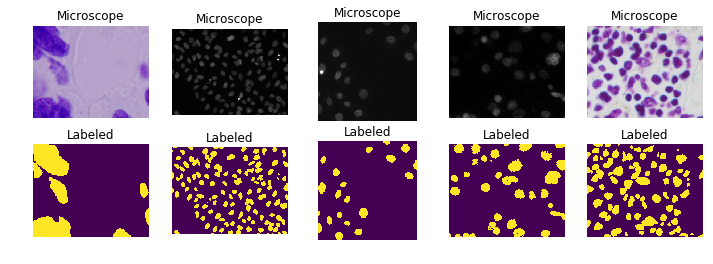

In [6]:
n_img = 5
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 5))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

### CHECK DIMENSIONS

In [6]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

### Making a simple CNN
Here we make a very simple CNN just to get a quick idea of how well it works. For this we use a batch normalization to normalize the inputs. We cheat a bit with the padding to keep problems simple.

In [7]:
input_shape = (256, 256, IMG_CHANNELS)
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = input_shape, name = 'NormalizeInput'))
simple_cnn.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
simple_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#simple_cnn.add(Dropout(0.2))
simple_cnn.add(Conv2D(64, (5, 5), activation='relu'))
simple_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#simple_cnn.add(Dropout(0.2))
simple_cnn.add(Flatten())
simple_cnn.add(Dense(1000, activation='relu'))
simple_cnn.add(Dense(2, activation='softmax'))
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 64)      51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 238144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              238145000 
__________

### LOSS
Since we are being evaulated with intersection over union we can use the inverse of the DICE score as the loss function to optimize

In [7]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

### TRAINING

In [ ]:
%%time
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

simple_cnn.fit_generator(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 10)

Epoch 1/10
670/670 [==============================] - 810s 1s/step - loss: -0.6986 - dice_coef: 0.6986 - acc: 0.8807 - mean_squared_error: 0.1146
Epoch 2/10
670/670 [==============================] - 640s 955ms/step - loss: -0.7886 - dice_coef: 0.7886 - acc: 0.9283 - mean_squared_error: 0.0707
Epoch 3/10
670/670 [==============================] - 684s 1s/step - loss: -0.7982 - dice_coef: 0.7982 - acc: 0.9302 - mean_squared_error: 0.0688
Epoch 4/10
670/670 [==============================] - 1026s 2s/step - loss: -0.7964 - dice_coef: 0.7964 - acc: 0.9277 - mean_squared_error: 0.0716
Epoch 5/10
670/670 [==============================] - 1069s 2s/step - loss: -0.8039 - dice_coef: 0.8039 - acc: 0.9318 - mean_squared_error: 0.0677
Epoch 6/10
670/670 [==============================] - 1066s 2s/step - loss: -0.8017 - dice_coef: 0.8017 - acc: 0.9304 - mean_squared_error: 0.0692
Epoch 7/10
670/670 [==============================] - 1052s 2s/step - loss: -0.8041 - dice_coef: 0.8041 - acc: 0.9303 

### SAVING THE WEIGHTS

In [20]:
model_json = simple_cnn.to_json()
with open('model2.json', 'w') as json_file:
    json_file.write(model_json)


In [21]:
simple_cnn.save_weights('model2.h5')

### APPLYING MODEL TO TEST

In [9]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
Wall time: 1.03 s


In [10]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 17.5 s


### SHOW A FEW PREDICTIONS

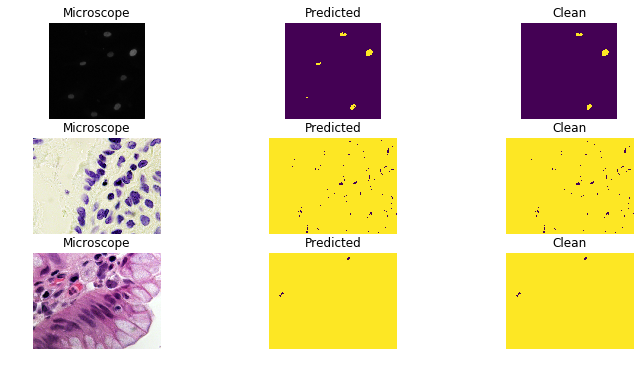

In [11]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

### CHECK RLE

In [12]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

#### Calculate the RLEs for a Train Image

In [13]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

#### Take the RLEs from the CSV

In [14]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

## CHECK
Since we made some simplifications, we don't expect everything to be perfect, but pretty close

In [15]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

#Matches: 360, Mismatches: 0, Accuracy: 1

Matches: 360, Mismatches: 0, Accuracy: 100.0%


## Calculate RLE for all the masks
Here we generate the RLE for all the masks and output the the results to a table. We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions, etc)

In [16]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [17]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1469 regions found for 65 images


,EncodedPixels,ImageId
105,148401 2 148405 2 148911 14 149422 17 149934 1...,1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1...
1080,64402 2 64919 6 65436 10 65954 12 66472 14 669...,ca20076870e8fb604e61802605a9ac45419c82dd3e2340...
1059,334497 2 335015 10 335534 13 336050 19 336568 ...,bdc789019cee8ddfae20d5f769299993b4b330b2d38d12...


In [18]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)